# Определение перспективного тарифа для телеком компании  
В рамках совершенствования тарифной политики компании клиентам оператора сотовой связи предлагают два тарифных плана: «Смарт» и «Ультра». 
Сделать предварительный анализ тарифов на небольшой выборке клиентов. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Содержание:
* [Шаг 1. Откройте файлы с данными и изучите общую информацию](#first-step)
* [Шаг 1. Вывод](#first-conclusion)
* [Шаг 2. Предобработка данных](#second-step)
* [Шаг 2. Вывод](#second-conclusion)
* [Шаг 3. Проанализируйте данные](#third-step)
* [Шаг 3. Промежуточные выводы](#third0-conclusion)
* [Шаг 3. Вывод](#third-conclusion)
* [Шаг 4. Проверьте гипотезы](#fourth-step)
* [Шаг 4. Вывод](#fourth-conclusion)
* [Шаг 5. Общий вывод](#fifth-step)

### Шаг 1. Откройте файлы с данными и изучите общую информацию. <a class="anchor" id="first-step"></a>

Описание данных

<ul>
    Таблица users (информация о пользователях):
<li>user_id — уникальный идентификатор пользователя</li>
<li>first_name — имя пользователя</li>
<li>last_name — фамилия пользователя</li>
<li>age — возраст пользователя (годы)</li>
<li>reg_date — дата подключения тарифа (день, месяц, год)</li>
<li>churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)</li>
<li>city — город проживания пользователя</li>
<li>tariff — название тарифного плана</li>
</ul>

<ul>Таблица calls (информация о звонках):
<li>id — уникальный номер звонка</li>
<li>call_date — дата звонка</li>
<li>duration — длительность звонка в минутах</li>
<li>user_id — идентификатор пользователя, сделавшего звонок</li>
</ul>
<ul>Таблица messages (информация о сообщениях):
<li>id — уникальный номер сообщения</li>
<li>message_date — дата сообщения</li>
<li>user_id — идентификатор пользователя, отправившего сообщение</li>
</ul>
<ul>Таблица internet (информация об интернет-сессиях):
<li>id — уникальный номер сессии</li>
<li>mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)</li>
<li>session_date — дата интернет-сессии</li>
<li>user_id — идентификатор пользователя</li>
</ul>
<ul>Таблица tariffs (информация о тарифах):
<li>tariff_name — название тарифа</li>
<li>rub_monthly_fee — ежемесячная абонентская плата в рублях</li>
<li>minutes_included — количество минут разговора в месяц, включённых в абонентскую плату</li>
<li>messages_included — количество сообщений в месяц, включённых в абонентскую плату</li>
<li>mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)</li>
<li>rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)</li>
<li>rub_per_message — стоимость отправки сообщения сверх тарифного пакета</li>
<li>rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)</li>
</ul>

In [1]:
import pandas as pd
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

pd.set_option('display.max_columns', None)

_Начнём от меньшего к большему. Посмотри на данные файла tariffs.csv_

In [2]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [3]:
df_tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


_Данные файла tariffs.csv не требуют какой-либо корректировки или предобработки перед анализом._  
_Напишем пару функций, которые помогут нам понять структуру даных в предоставленных файлах._

In [4]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [5]:
def file_info(df):
    printmd('**Общая информация - метод info**')
    print(df.info())
    for col in df.columns:
        temp_str = '**Описание столбца ' + col + '**'
        printmd(temp_str)
        print(df[col].describe())
        if col == 'user_id':
            temp_str = '**Количество уникальных значений столбца ' + col + '**'
            printmd(temp_str)
            print(df[col].unique().size)         
    printmd('**Первые пять строк**')
    print(df.head())
    printmd('**Последние пять строк**')
    print(df.tail())
    printmd('**Есть ли дубликаты**')
    print(df_messages.duplicated().sum())
    

_Далее разберём файл messages.csv_

In [6]:
file_info(df_messages)

**Общая информация - метод info**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


**Описание столбца id**

count      123036
unique     123036
top       1337_96
freq            1
Name: id, dtype: object


**Описание столбца message_date**

count         123036
unique           364
top       2018-12-31
freq             859
Name: message_date, dtype: object


**Описание столбца user_id**

count    123036.000000
mean       1256.989410
std         143.523967
min        1000.000000
25%        1134.000000
50%        1271.000000
75%        1381.000000
max        1499.000000
Name: user_id, dtype: float64


**Количество уникальных значений столбца user_id**

426


**Первые пять строк**

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000


**Последние пять строк**

              id message_date  user_id
123031  1499_179   2018-12-12     1499
123032  1499_180   2018-09-28     1499
123033  1499_181   2018-09-27     1499
123034  1499_182   2018-11-15     1499
123035  1499_183   2018-11-16     1499


**Есть ли дубликаты**

0


_Итак, файл не имеет пропущенных данных. Это хорошо. Столбец id имет только уникальные значения._  
<font color="DodgerBlue"> Столбец **message_date** имеет неправильный тип, его надо сменить на datetime. Столбец id</font>  
_Следующий файл calls.csv_

In [7]:
file_info(df_calls)

**Общая информация - метод info**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


**Описание столбца id**

count       202607
unique      202607
top       1146_330
freq             1
Name: id, dtype: object


**Описание столбца call_date**

count         202607
unique           365
top       2018-12-31
freq            1435
Name: call_date, dtype: object


**Описание столбца duration**

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64


**Описание столбца user_id**

count    202607.000000
mean       1253.940619
std         144.722751
min        1000.000000
25%        1126.000000
50%        1260.000000
75%        1379.000000
max        1499.000000
Name: user_id, dtype: float64


**Количество уникальных значений столбца user_id**

492


**Первые пять строк**

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000


**Последние пять строк**

              id   call_date  duration  user_id
202602  1499_215  2018-12-26      0.76     1499
202603  1499_216  2018-10-18     18.83     1499
202604  1499_217  2018-11-10     10.81     1499
202605  1499_218  2018-10-06      4.27     1499
202606  1499_219  2018-12-14     19.62     1499


**Есть ли дубликаты**

0


_Итак, файл не имеет пропущенных данных. Это хорошо. Столбец id имет только уникальные значения._  
<font color="DodgerBlue"> Столбец **call_date** имеет неправильный тип, его надо сменить на datetime.</font>  
_Следующий файл internet.csv_

In [8]:
file_info(df_internet)

**Общая информация - метод info**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None


**Описание столбца id**

count      149396
unique     149396
top       1337_96
freq            1
Name: id, dtype: object


**Описание столбца mb_used**

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64


**Описание столбца session_date**

count         149396
unique           365
top       2018-12-31
freq            1057
Name: session_date, dtype: object


**Описание столбца user_id**

count    149396.000000
mean       1252.099842
std         144.050823
min        1000.000000
25%        1130.000000
50%        1251.000000
75%        1380.000000
max        1499.000000
Name: user_id, dtype: float64


**Количество уникальных значений столбца user_id**

497


**Первые пять строк**

       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000


**Последние пять строк**

              id  mb_used session_date  user_id
149391  1499_152   318.90   2018-10-03     1499
149392  1499_153   490.13   2018-12-14     1499
149393  1499_154     0.00   2018-10-27     1499
149394  1499_155  1246.32   2018-11-26     1499
149395  1499_156   544.37   2018-10-26     1499


**Есть ли дубликаты**

0


_Итак, файл не имеет пропущенных данных. Это хорошо. Столбец id имет только уникальные значения._  
<font color="DodgerBlue"> Столбец **session_date** имеет неправильный тип, его надо сменить на datetime.</font>  
_Следующий файл users.csv_

In [9]:
pd.set_option('display.width', 120)
file_info(df_users)

**Общая информация - метод info**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


**Описание столбца user_id**

count     500.000000
mean     1249.500000
std       144.481833
min      1000.000000
25%      1124.750000
50%      1249.500000
75%      1374.250000
max      1499.000000
Name: user_id, dtype: float64


**Количество уникальных значений столбца user_id**

500


**Описание столбца age**

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64


**Описание столбца churn_date**

count             38
unique            33
top       2018-12-21
freq               2
Name: churn_date, dtype: object


**Описание столбца city**

count        500
unique        76
top       Москва
freq          99
Name: city, dtype: object


**Описание столбца first_name**

count       500
unique      246
top       Радим
freq          6
Name: first_name, dtype: object


**Описание столбца last_name**

count           500
unique          419
top       Андреенко
freq              5
Name: last_name, dtype: object


**Описание столбца reg_date**

count            500
unique           270
top       2018-05-28
freq               8
Name: reg_date, dtype: object


**Описание столбца tariff**

count       500
unique        2
top       smart
freq        351
Name: tariff, dtype: object


**Первые пять строк**

   user_id  age churn_date         city first_name  last_name    reg_date tariff
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25  ultra
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01  smart
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17  smart
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17  ultra
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14  ultra


**Последние пять строк**

     user_id  age  churn_date         city first_name last_name    reg_date tariff
495     1495   65         NaN      Иркутск  Авксентий     Фокин  2018-08-28  ultra
496     1496   36         NaN      Вологда     Трифон    Блохин  2018-01-27  smart
497     1497   32         NaN    Челябинск   Каролина    Агеева  2018-10-09  smart
498     1498   68  2018-10-25  Владикавказ   Всеволод   Акимчин  2018-07-19  smart
499     1499   35         NaN        Пермь     Гектор  Корнилов  2018-09-27  smart


**Есть ли дубликаты**

0


In [10]:
df_users[~df_users['churn_date'].isna()].head() 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


In [11]:
df_users['city'].value_counts() #какие города

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Нижневартовск       1
Иваново             1
Химки               1
Подольск            1
Name: city, Length: 76, dtype: int64

In [12]:
df_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

### Вывод <a class="anchor" id="first-conclusion"></a>

1. В файле users.csv есть пропущенные значения в столбце **churn_date** - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Пропущенные значения мы заменим на 9999:01:01 и затем проеобразуем тип в datetime
2. В файле users.csv у столбца **reg_date** поменяем тип на datetime
3. В файле calls.csv у столбца **call_date** поменяем тип на datetime
4. В файле messages.csv у столбца **message_date** поменяем тип на datetime
5. В файле internet.csv у столбца **session_date** поменяем тип на datetime
6. В файлах calls.csv, messages.csv, internet.csv уникальных значений у столбца **user_id**  меньше 500. А, в файле users.csv столбец **user_id** имеет 500 уникальных значений. Это говорит нам о том, что кто-то не пользовался какими-то услугами опреатора.
7. В файле calls.csv столбец **duration** — длительность звонка в минутах, имеет нулевые значения
8. В файле internet.csv столбец **mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах), имеет нулевые значения

### Шаг 2. Предобработка данных <a class="anchor" id="second-step"></a>

_Приведём данные к нужным типам.  
Найдём и исправим ошибки в данных.  
Поясним, какие ошибки мы нашли и как их исправили.  
Обратите внимание, что у большого количества звонков длительность — 0.0 минут. Это проблема в данных, нужна предобработка._

_Посчитаем для каждого пользователя:_  
<blockquote>количество сделанных звонков и израсходованных минут разговора по месяцам;</blockquote>
<blockquote>количество отправленных сообщений по месяцам;</blockquote>
<blockquote>объем израсходованного интернет-трафика по месяцам;</blockquote>
<blockquote>помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).</blockquote>

_Преобразуем столбцы с датой. Пропущенные значения в столбце **churn_date** заменим максимальной возможной датой, т.е. датой с далекого будущего_

In [13]:
date_fillna = pd.Timestamp.max.strftime('%Y-%m-%d') #максимально допустимая дата
df_users['churn_date'] = df_users['churn_date'].fillna(date_fillna) #заполним пропущенные значения в столбце **churn_date**
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')

In [14]:
df_users.info() #преобразование прошло успешно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [15]:
from IPython.display import display
def print_fist_row(df): # функция вывода первой строчки из таблицы
    display(df.head(1))
    print('')

In [16]:
def add_columns_date(df): # функция создания столбцов год, месяц и день недели из значений столбцов с датами 
    temp_list = {'reg_date','call_date','message_date','session_date'}
    new_name_col_year = ''
    new_name_col_month = ''
    new_name_col_dayweek = ''
    try:
        for temp_col in temp_list:
            if temp_col in df.columns:
                new_name_col_year = temp_col + '_year'
                new_name_col_month = temp_col + '_month'
                new_name_col_dayweek = temp_col + '_dayweek'
                df[new_name_col_year] = df[temp_col].dt.year
                df[new_name_col_month] = df[temp_col].dt.month
                df[new_name_col_dayweek] = df[temp_col].dt.day_name()
    except: print('Ошибка создания столбцов при обработке столбца', temp_col)
            
            

_Добавим стобцы в таблицы и распечатаем первую строку, чтобы посмотреть на результат_

In [17]:
add_columns_date(df_calls)
add_columns_date(df_internet)
add_columns_date(df_messages)
add_columns_date(df_users)

In [18]:
print_fist_row(df_calls)
print_fist_row(df_internet)
print_fist_row(df_messages)
print_fist_row(df_users)

,id,call_date,duration,user_id,call_date_year,call_date_month,call_date_dayweek
0,1000_0,2018-07-25,0.0,1000,2018,7,Wednesday


,id,mb_used,session_date,user_id,session_date_year,session_date_month,session_date_dayweek
0,1000_0,112.95,2018-11-25,1000,2018,11,Sunday


,id,message_date,user_id,message_date_year,message_date_month,message_date_dayweek
0,1000_0,2018-06-27,1000,2018,6,Wednesday


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_year,reg_date_month,reg_date_dayweek
0,1000,52,2262-04-11,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,Friday


In [19]:
#не помню для чего
#dpt_duration = df_calls.groupby('user_id').agg({'duration': ['median']})
#dpt_duration.columns = ['duration_median']
#dpt_duration = dpt_duration.reset_index()
#dpt_duration.head()
#
#dpt_mb_used = df_internet.groupby('user_id').agg({'mb_used': ['median']})
#dpt_mb_used.columns = ['mb_used_median']

_Посмотрим сколько нулевых интернет-сессий и звонков с нулевой длительностью_

In [20]:
df_calls.query('duration == 0.0')['duration'].count()

39613

In [21]:
df_internet.query('mb_used == 0.0')['mb_used'].count()

19598

_Все такие записи считаем несвершившимяся, либо звонок не удался, либо интернет-сессия не могла установиться. Причины на это могут быть разными. Например, плохое качество связи в районе клиента, метро или удалённая деревня.  
Посмотрим на отношение несвершившихся звонков к выполненым у клиентов_

In [22]:
df_calls1 = df_calls.query('duration == 0.0').groupby('user_id').agg({'duration': ['count']}) 
df_calls1.columns = ['duration_count0'] # сгрупируем по пользователям и посчитаем количество невыполненых звонков
df_calls2 = df_calls.query('duration > 0.0').groupby('user_id').agg({'duration': ['count']})
df_calls2.columns = ['duration_count_more0'] # сгрупируем по пользователям и посчитаем количество выполненых звонков
df_calls3 = df_calls1.join(df_calls2) #объединим таблицы
df_calls3['ration'] = df_calls3['duration_count0'] / df_calls3['duration_count_more0'] #почитаем отношение
df_calls3.sort_values('ration',ascending=False ).head()

,duration_count0,duration_count_more0,ration
user_id,,,
1257,7,7,1.000000
1181,25,53,0.471698
1398,16,37,0.432432
1016,6,14,0.428571
1373,7,17,0.411765


_у некоторых клиентов это отношение очень высокое. примерно 40-50% не удачных звонков.  
Посмотрим на отношение несвершившихся интерне-сессий к выполненым у клиентов_

In [23]:
df_internet1 = df_internet.query('mb_used == 0.0').groupby('user_id').agg({'mb_used': ['count']})
df_internet1.columns = ['mb_used_count0']  # сгрупируем по пользователям и посчитаем количество невыполненых сессий
df_internet2 = df_internet.query('mb_used > 0.0').groupby('user_id').agg({'mb_used': ['count']})
df_internet2.columns = ['mb_used_count_more0'] # сгрупируем по пользователям и посчитаем количество выполненых сессий
df_internet3 = df_internet1.join(df_internet2) #объединим таблицы
df_internet3['ration'] = df_internet3['mb_used_count0'] / df_internet3['mb_used_count_more0'] #почитаем отношение
df_internet3.sort_values('ration',ascending=False ).head()

,mb_used_count0,mb_used_count_more0,ration
user_id,,,
1434,13,39,0.333333
1041,22,69,0.318841
1190,11,35,0.314286
1351,14,46,0.304348
1322,49,170,0.288235


_Не свершившиеся события удалим из таблиц, а время звонка и количество мегабайтов интернет-сессии округлим до большего целого, 
как того требуют правила компании:_ 
>Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. 

_Посмотрим на таблицы перед измененем_

In [24]:
df_calls.head(2)

,id,call_date,duration,user_id,call_date_year,call_date_month,call_date_dayweek
0,1000_0,2018-07-25,0.0,1000,2018,7,Wednesday
1,1000_1,2018-08-17,0.0,1000,2018,8,Friday


In [25]:
df_internet.head(2)

,id,mb_used,session_date,user_id,session_date_year,session_date_month,session_date_dayweek
0,1000_0,112.95,2018-11-25,1000,2018,11,Sunday
1,1000_1,1052.81,2018-09-07,1000,2018,9,Friday


In [26]:
calls_count_before = df_calls.shape[0] #количество записей в таблице до изменения
df_calls = df_calls.query('duration > 0.0') #убераем нулевые значения в столбце duration
calls_count_after = df_calls.shape[0]  #количество записей в таблице после изменения
print('Уменьшили таблицу calls на {:.0%}'.format((calls_count_before - calls_count_after)/calls_count_before ))
print('Было {}, стало {}'.format(calls_count_before,calls_count_after))
internet_count_before = df_internet.shape[0] #количество записей в таблице до изменения
df_internet = df_internet.query('mb_used > 0.0') #убераем нулевые значения в столбце mb_used
internet_count_after = df_internet.shape[0]  #количество записей в таблице после изменения
print('Уменьшили таблицу internet на {:.0%}'.format((internet_count_before - internet_count_after)/internet_count_before ))
print('Было {}, стало {}'.format(internet_count_before,internet_count_after))

Уменьшили таблицу calls на 20%
Было 202607, стало 162994
Уменьшили таблицу internet на 13%
Было 149396, стало 129798


In [27]:
import numpy as np
df_calls['duration'] = df_calls['duration'].apply(np.ceil) #округление значений до большего целого числа
df_calls['duration'] = df_calls['duration'].astype('int') #преобразование типов
df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil)  #округление значений до большего целого числа
df_internet['mb_used'] = df_internet['mb_used'].astype('int') #преобразование типов

In [28]:
df_calls.head(2)

,id,call_date,duration,user_id,call_date_year,call_date_month,call_date_dayweek
2,1000_2,2018-06-11,3,1000,2018,6,Monday
3,1000_3,2018-09-21,14,1000,2018,9,Friday


In [29]:
df_internet.head(2)

,id,mb_used,session_date,user_id,session_date_year,session_date_month,session_date_dayweek
0,1000_0,113,2018-11-25,1000,2018,11,Sunday
1,1000_1,1053,2018-09-07,1000,2018,9,Friday


_Много пришлось удалить данных, но они ни как не влияли на подсчёт прибыль от клиентов, хотя стоило бы задуматься компании, почему так много несвершившихся звонков на её сети.
Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам._

In [30]:
#df_calls_count_pv_users количество сделанных звонков для каждого пользователя по месяцам.
df_calls_count_pv_users = df_calls.pivot_table(index='user_id',columns = 'call_date_month',
                               values='duration', aggfunc='count', fill_value = 0)
df_calls_count_pv_users.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #переименование столбцов в сводной таблице
df_calls_count_pv_users = df_calls_count_pv_users.reset_index() #сброс индекса
df_calls_count_pv_users = df_calls_count_pv_users.merge(
    df_users[['user_id','tariff']], on='user_id', how='inner') #объеденяем таблицы

#df_calls_pv_users количество израсходованных минут разговора для каждого пользователя по месяцам.
df_calls_pv_users = df_calls.pivot_table(index='user_id',columns = 'call_date_month',
                               values='duration', aggfunc='sum', fill_value = 0)
df_calls_pv_users.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #переименование столбцов в сводной таблице
df_calls_pv_users = df_calls_pv_users.reset_index()  #сброс индекса
df_calls_pv_users = df_calls_pv_users.merge(df_users[['user_id','tariff']], on='user_id', how='inner') #объеденяем таблицы
df_calls_pv_users.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0,0,0,0,159,172,340,408,466,350,338,333,ultra
1,1001,0,0,0,0,0,0,0,0,0,0,430,414,smart
2,1002,0,0,0,0,0,117,214,289,206,212,243,236,smart
3,1003,0,0,0,0,0,0,0,380,961,855,824,802,ultra
4,1004,0,0,0,0,35,171,135,137,117,145,117,130,ultra


_Добавляем столбец **minutes_included**, где записано количество включённых минут в тариф._

In [31]:
df_calls_pv_users['minutes_included'] = df_calls_pv_users.apply(lambda x: 500 if x.tariff == 'smart' else 3000, axis = 1)
df_calls_pv_users.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,minutes_included
0,1000,0,0,0,0,159,172,340,408,466,350,338,333,ultra,3000
1,1001,0,0,0,0,0,0,0,0,0,0,430,414,smart,500
2,1002,0,0,0,0,0,117,214,289,206,212,243,236,smart,500
3,1003,0,0,0,0,0,0,0,380,961,855,824,802,ultra,3000
4,1004,0,0,0,0,35,171,135,137,117,145,117,130,ultra,3000


In [32]:
df_calls_pv_users1 = df_calls_pv_users.copy() #в таблице будет содержаться минуты сверх тарифа
for i in range(1,13): #для каждой ячейке вычитаем количество минут сверх в тариф
    df_calls_pv_users1[i] = df_calls_pv_users1.apply(
        lambda x: 0 if (x['minutes_included'] - x[i]) > 0 else x[i] - x['minutes_included'], axis = 1)

In [33]:
for i in range(1,13): # в таблице будет содержваться прибыль от минут сверх тарифа по месяцам
    df_calls_pv_users1[i] = df_calls_pv_users1.apply(
        lambda x: x[i] if x.tariff == 'ultra' else x[i] * 3 , axis = 1)
#df_calls_pv_users1 содержит прибыль от минут сверх тарифа по каждому пользователю по месяцам
df_calls_pv_users = df_calls_pv_users.drop('minutes_included', axis=1)
df_calls_pv_users1 = df_calls_pv_users1.drop('minutes_included', axis=1)
df_calls_pv_users1.tail()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
487,1495,0,0,0,0,0,0,0,0,0,0,0,0,ultra
488,1496,0,282,171,63,0,165,246,81,0,0,486,54,smart
489,1497,0,0,0,0,0,0,0,0,0,0,0,135,smart
490,1498,0,0,0,0,0,0,0,0,0,0,0,0,smart
491,1499,0,0,0,0,0,0,0,0,0,0,336,0,smart


_Итак получили три таблицы:  
df_calls_count_pv_users - количество сделанных звонков для каждого пользователя по месяцам  
df_calls_pv_users - общее количество минут у каждого пользователя по месяцам  
df_calls_pv_users1 - прибыль от минут сверх тарифа у каждого пользователя по месяцам_

_Поработаем с таблицей messages_
<ul>
<li>Создадим сводную таблицу количества отправленных сообщений для каждого пользователя по месяцам</li>
<li>Высчитаем количество сообщений отправленых клиентом сверх тарифа по месяцам</li>
<li>Посчитаем прибыль от сообщений отправленых клиентом сверх тарифа по месяцам</li>
</ul>

In [34]:
#df_messages_pv_users количества отправленных сообщений для каждого пользователя по месяцам.
df_messages_pv_users = df_messages.pivot_table(index='user_id',columns = 'message_date_month',
                               values='id', aggfunc='count', fill_value = 0)
df_messages_pv_users.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #переименование столбцов в сводной таблице
df_messages_pv_users = df_messages_pv_users.reset_index() #сброс индекса
df_messages_pv_users = df_messages_pv_users.merge(df_users[['user_id','tariff']], on='user_id', how='inner')
#Добавляем столбец messages_included, где записано количество включённых сообщений в тариф.
df_messages_pv_users['messages_included'] = df_messages_pv_users.apply(lambda x: 50 if x.tariff == 'smart' else 1000, axis = 1)
df_messages_pv_users.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,messages_included
0,1000,0,0,0,0,22,60,75,81,57,73,58,70,ultra,1000
1,1002,0,0,0,0,0,4,11,13,4,10,16,12,smart,50
2,1003,0,0,0,0,0,0,0,37,91,83,94,75,ultra,1000
3,1004,0,0,0,0,95,134,181,151,146,165,158,162,ultra,1000
4,1005,7,38,56,41,42,47,56,64,52,44,51,54,smart,50


In [35]:
df_messages_pv_users1 = df_messages_pv_users.copy() #в таблице будет содержаться количество сообщений сверх тарифа
for i in range(1,13): #для каждой ячейке вычитаем количество сообщений сверх в тариф
    df_messages_pv_users1[i] = df_messages_pv_users1.apply(
        lambda x: 0 if (x['messages_included'] - x[i]) > 0 else x[i] - x['messages_included'], axis = 1)

In [36]:
for i in range(1,13):
    df_messages_pv_users1[i] = df_messages_pv_users1.apply(
        lambda x: x[i] if x.tariff == 'ultra' else x[i] * 3 , axis = 1)
#df_messages_pv_users1 содержит прибыль от сообщений сверх тарифа по каждому пользователю по месяцам 
df_messages_pv_users  = df_messages_pv_users.drop('messages_included', axis=1)
df_messages_pv_users1 = df_messages_pv_users1.drop('messages_included', axis=1)
df_messages_pv_users1.tail()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
421,1495,0,0,0,0,0,0,0,0,0,0,0,0,ultra
422,1496,0,0,0,0,0,0,0,0,0,0,0,3,smart
423,1497,0,0,0,0,0,0,0,0,0,0,0,0,smart
424,1498,0,0,0,0,0,0,0,36,0,0,0,0,smart
425,1499,0,0,0,0,0,0,0,0,0,0,27,48,smart


_Итак получили две таблицы:  
df_messages_pv_users - общее количество отправленых сообщений у каждого пользователя по месяцам  
df_messages_pv_users1 - прибыль от отправленых сообщений сверх тарифа у каждого пользователя по месяцам_

_Поработаем с таблицей internet_
<ul>
<li>Создадим сводную таблицу количества потраченнего трафика для каждого пользователя по месяцам</li>
<li>Высчитаем количество потраченнего трафика клиентом сверх тарифа по месяцам</li>
<li>Посчитаем прибыль от потраченнего трафика клиентом сверх тарифа по месяцам</li>
</ul>

In [37]:
df_internet_pv_users = df_internet.pivot_table(index='user_id',columns = 'session_date_month',
                               values='mb_used', aggfunc='sum', fill_value = 0)
df_internet_pv_users.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_internet_pv_users = df_internet_pv_users.reset_index()
df_internet_pv_users = df_internet_pv_users.merge(df_users[['user_id','tariff']], on='user_id', how='inner')
df_internet_pv_users['mb_per_month_included'] = df_internet_pv_users.apply(
    lambda x: 15360 if x.tariff == 'smart' else 30720 , axis = 1)
df_internet_pv_users.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,mb_per_month_included
0,1000,0,0,0,0,2256,23257,14016,14070,14581,14717,14768,9827,ultra,30720
1,1001,0,0,0,0,0,0,0,0,0,0,18452,14053,smart,15360
2,1002,0,0,0,0,0,10871,17601,20347,16712,13905,18610,18137,smart,15360
3,1003,0,0,0,0,0,0,0,8571,12479,14779,11368,10132,ultra,30720
4,1004,0,0,0,0,13415,17619,22243,28607,15125,18494,15631,18038,ultra,30720


In [38]:
df_internet_pv_users1 = df_internet_pv_users.copy() #в таблице будет содержаться количество трафика сверх тарифа
for i in range(1,13):
    df_internet_pv_users1[i] = df_internet_pv_users1.apply(
        lambda x: 0 if (x['mb_per_month_included'] - x[i]) > 0 else x[i] - x['mb_per_month_included'], axis = 1)

In [39]:
for i in range(1,13):
    df_internet_pv_users1[i] = df_internet_pv_users1.apply(
        lambda x: np.ceil(x[i] / 1024) * 150 if x.tariff == 'ultra' else np.ceil(x[i] / 1024) * 200  , axis = 1)
for i in range(1,13):
    df_internet_pv_users1[i] = df_internet_pv_users1[i].astype('int')

df_internet_pv_users = df_internet_pv_users.drop('mb_per_month_included', axis=1)
df_internet_pv_users1 = df_internet_pv_users1.drop('mb_per_month_included', axis=1)
df_internet_pv_users1.tail() #прибыль от потраченнего трафика клиентом сверх тарифа по месяцам

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
492,1495,0,0,0,0,0,0,0,0,450,0,1350,0,ultra
493,1496,0,2600,2000,1200,1800,1000,1800,1800,2400,2600,2000,1200,smart
494,1497,0,0,0,0,0,0,0,0,0,0,0,1000,smart
495,1498,0,0,0,0,0,0,0,1800,1400,1200,0,0,smart
496,1499,0,0,0,0,0,0,0,0,0,600,600,0,smart


_Итак получили две таблицы:  
df_internet_pv_users - общее количество трафика у каждого пользователя по месяцам  
df_internet_pv_users1 - прибыль от трафика сверх тарифа у каждого пользователя по месяцам_

_Создадим таблицу прибыли от каждого клиента по месяцам_  
1. Создадим таблицу активности пользователей по месяцам, которую получим сложением таблиц с минутами, сообщениями и мегабайтами потраченными пользователями по месяцам. В итоге у нас получится таблица с ненулевыми значениями по месяцам.  
2. Соответственно все ненулевые значения мы заменяем на значения базового тарифа.  
3. К получившийся таблице добавим таблицы с прибылью от минут, сообщений и гигабайтов потраченными пользователями сверх тарифа по месяцам.

In [40]:
df_users_profit_t = df_users[['user_id', 'tariff']].copy() #таблица совсеми пользователями и нулевыми значениями по мясецам
for i in range(1,13):
    df_users_profit_t[i] = df_users_profit_t.apply(lambda x: 0  , axis = 1)
    
    
df_users_profit_t = df_users_profit_t.set_index(['user_id', 'tariff']) #зададим новые индексы
df_internet_pv_users = df_internet_pv_users.set_index(['user_id', 'tariff']) #зададим новые индексы
df_calls_pv_users = df_calls_pv_users.set_index(['user_id', 'tariff']) #зададим новые индексы
df_messages_pv_users = df_messages_pv_users.set_index(['user_id', 'tariff']) #зададим новые индексы

take_sum = lambda s1, s2: s1 + s2

df_users_profit2_t = df_users_profit_t.combine(df_messages_pv_users, take_sum, fill_value=0) #объединяем и суммируем значения
df_users_profit2_t = df_users_profit2_t.combine(df_internet_pv_users, take_sum, fill_value=0) #объединяем и суммируем значения
df_users_profit2_t = df_users_profit2_t.combine(df_calls_pv_users, take_sum, fill_value=0) #объединяем и суммируем значения
df_users_profit2_t = df_users_profit2_t.reset_index()

df_users_profit_t = df_users_profit_t.reset_index() #возвращаем индекцы
df_internet_pv_users = df_internet_pv_users.reset_index() #возвращаем индекцы
df_calls_pv_users = df_calls_pv_users.reset_index() #возвращаем индекцы
df_messages_pv_users = df_messages_pv_users.reset_index() #возвращаем индекцы

df_users_profit2_t.head() #Здесь у нас количественные значения использования услуг клиентами по месяцам.

,user_id,tariff,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,0,0,0,0,2437,23489,14431,14559,15104,15140,15164,10230
1,1001,smart,0,0,0,0,0,0,0,0,0,0,18882,14467
2,1002,smart,0,0,0,0,0,10992,17826,20649,16922,14127,18869,18385
3,1003,ultra,0,0,0,0,0,0,0,8988,13531,15717,12286,11009
4,1004,ultra,0,0,0,0,13545,17924,22559,28895,15388,18804,15906,18330


In [41]:
for i in range(1,13):
    df_users_profit2_t.loc[df_users_profit2_t['tariff'] == 'ultra', i] = df_users_profit2_t.query('tariff == "ultra"').apply(
        lambda x: 1950  if  x[i] > 0 else x[i], axis = 1)

for i in range(1,13):
    df_users_profit2_t.loc[df_users_profit2_t['tariff'] == 'smart', i] = df_users_profit2_t.query('tariff == "smart"').apply(
        lambda x: 550  if  x[i] > 0 else x[i], axis = 1)
    
df_users_profit2_t.head()  #здесь у нас значения базового тарифам в те месяцы, когда был активен клиент

,user_id,tariff,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1001,smart,0,0,0,0,0,0,0,0,0,0,550,550
2,1002,smart,0,0,0,0,0,550,550,550,550,550,550,550
3,1003,ultra,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
4,1004,ultra,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950


In [42]:
#неудачные варианты
#df = df_users_profit.set_index(['user_id', 'tariff']).add(
#    df_internet_pv_users1.set_index(['user_id', 'tariff']), fill_value=0).reset_index()
#pd.merge(df_users_profit, df_internet_pv_users1, on=['user_id', 'tariff']).set_index(['user_id', 'tariff']).sum(axis=1)
#df_users_profit2 = df_users_profit + df_internet_pv_users1# + df_messages_pv_users1 #+ df_calls_pv_users1

_Просуммируем прибыль от клиента по месяцам от базового тарифа, от интернет-трафика сверх тарифа, от сообщений сверх тарифа и от звонков сверх тарифа_

In [43]:
df_users_profit = df_users_profit2_t.copy()
df_users_profit = df_users_profit.set_index(['user_id', 'tariff']) #зададим новые индексы
df_internet_pv_users1 = df_internet_pv_users1.set_index(['user_id', 'tariff']) #зададим новые индексы
df_calls_pv_users1 = df_calls_pv_users1.set_index(['user_id', 'tariff']) #зададим новые индексы
df_messages_pv_users1 = df_messages_pv_users1.set_index(['user_id', 'tariff']) #зададим новые индексы

take_sum = lambda s1, s2: s1 + s2

df_users_profit2 = df_users_profit.combine(df_messages_pv_users1, take_sum, fill_value=0) #объединяем и суммируем значения
df_users_profit2 = df_users_profit2.combine(df_internet_pv_users1, take_sum, fill_value=0) #объединяем и суммируем значения
df_users_profit2 = df_users_profit2.combine(df_calls_pv_users1, take_sum, fill_value=0) #объединяем и суммируем значения
df_users_profit2 = df_users_profit2.reset_index()
df_users_profit2.head()

df_users_profit = df_users_profit.reset_index() #возвращаем индекцы
df_internet_pv_users1 = df_internet_pv_users1.reset_index() #возвращаем индекцы
df_calls_pv_users1 = df_calls_pv_users1.reset_index() #возвращаем индекцы
df_messages_pv_users1 = df_messages_pv_users1.reset_index() #возвращаем индекцы

In [44]:
df_users_profit2.head()

,user_id,tariff,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1001,smart,0,0,0,0,0,0,0,0,0,0,1350,550
2,1002,smart,0,0,0,0,0,550,1150,1550,950,550,1350,1150
3,1003,ultra,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
4,1004,ultra,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950


_В таблице **df_users_profit2** теперь хранится помесячная выручка с каждого пользователя 
(вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
 остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)_

_Категоризируем местопроживание в таблице df_users_

In [45]:
df_users['city_M'] = df_users.apply(
        lambda x: 'Москва'  if x.city == 'Москва' else 'Другой'  , axis = 1)

### Вывод. <a class="anchor" id="second-conclusion"></a>

<ul>
<li>Преобразовали все столбцы с датой к правильному типу</li>
<li>Удалили несостоявшиеся звоник и интернет-соединения, это 20% данных из таблицы calls и 13% из таблицы internet</li>
    
Посчитали для каждого пользователя:
<li>количество сделанных звонков и израсходованных минут разговора по месяцам;</li>
<li>количество отправленных сообщений по месяцам;</li>
<li>объем израсходованного интернет-трафика по месяцам;</li>
<li>помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).</li>
    
_У некоторых пользователей очень большой процент несовершённых звонков или неустановленных интернет-соединений, возможно у них есть проблемы со связью в местах их нахождения_
</ul>

### Шаг 3. Проанализируйте данные <a class="anchor" id="third-step"></a>

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

<ul>
У нас есть восемь таблиц:
<li>df_calls_count_pv_users - количество сделанных звонков для каждого пользователя по месяцам.</li>
<li>df_calls_pv_users - количество израсходованных минут разговора для каждого пользователя по месяцам.</li>
<li>df_calls_pv_users1 - содержит прибыль от минут сверх тарифа по каждому пользователю по месяцам.</li>
<li>df_messages_pv_users - количество отправленных сообщений для каждого пользователя по месяцам.</li>
<li>df_messages_pv_users1 - содержит прибыль от сообщений сверх тарифа по каждому пользователю по месяцам.</li>
<li>df_internet_pv_users - количества потраченнего трафика для каждого пользователя по месяцам.</li>
<li>df_internet_pv_users1 - прибыль от потраченнего трафика клиентом сверх тарифа по месяцам.</li>
<li>df_users_profit2 - суммарная прибыль от клиентов по месяцам.</li>   
</ul>

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

_Преобразуем таблицу **df_users_profit2**, где хранится помесячная выручка с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану) для удобства визуализации._

In [47]:
df_users_profit3 = df_users_profit2.melt(id_vars=['user_id', 'tariff'], 
        var_name='Month',
        value_name='Profit')
df_users_profit3 = df_users_profit3.merge(df_users[['user_id','city_M']], on='user_id', how='inner')
#print(df_users_profit3.query('Profit != 0')['Profit'].count() / df_users_profit3['Profit'].count())
df_users_profit3 = df_users_profit3.query('Profit != 0')

In [48]:
df_users_profit3.head(2)

,user_id,tariff,Month,Profit,city_M
4,1000,ultra,5,1950,Другой
5,1000,ultra,6,1950,Другой


_Количество клиентов непостоянно на протяжениии всего года, оно растёт с начало года к концу_

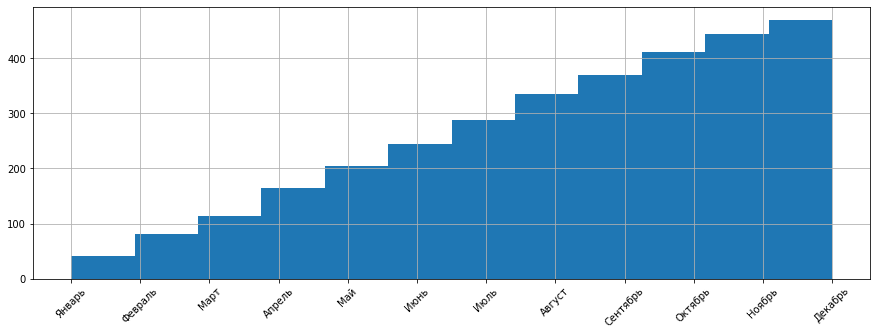

In [49]:
s3 = df_calls.groupby(['call_date_month','user_id']).duration.sum()
s3 = s3.reset_index()
fig = plt.figure(figsize=(15,5))
plt.xticks(range(1,13), ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль',
                  'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
plt.xticks(rotation=45)
s3['call_date_month'].hist(bins = 12)

Подсчитаем количество клиентов по каждому тарифу.

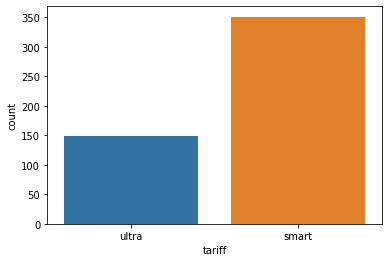

In [50]:
sns.countplot(x='tariff', data=df_users_profit2);

Количество клиентов тарифа smart почти в 2.5 раза выше количества клиентов тарифа ultra

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

def print_df(df, title, ylable):
    df_m1 = df.copy()
    df_m1 = df_m1.melt(id_vars=['user_id','tariff'], var_name='Value_per_Month', value_name='Month')
    df_m1.columns = ['user_id','tariff', 'Month' ,'Value_per_Month']
    df_m1 = df_m1.query('Value_per_Month != 0') #удалим нулевые значения
    fig = plt.figure(figsize=(15,5))
    plt.xticks(range(1,13), ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль',
                      'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
    plt.xticks(rotation=45) 
    plt.title(title)
    sns.lineplot(x = 'Month', y = 'Value_per_Month' , hue = 'tariff', data = df_m1)  
    plt.xlabel('Месяцы')
    plt.ylabel(ylable)

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

def print_df1(df, title, ylable, func):
    df_m1 = df.copy() #создаём копию входящей таблицы
    df_m1 = df_m1.melt(id_vars=['user_id','tariff'], var_name='Value_per_Month', value_name='Month') #переворачиваем столбцы
    df_m1.columns = ['user_id','tariff', 'Month' ,'Value_per_Month']
    df_m1 = df_m1.query('Value_per_Month != 0') #удалим нулевые значения
    df_m1 = df_m1.pivot_table(index = ['tariff','Month'],values = 'Value_per_Month', aggfunc = func)
    df_m1 = df_m1.reset_index()
    fig = plt.figure(figsize=(15,5))
    for x,y in zip(df_m1['Month'],df_m1['Value_per_Month']):

        label = "{:.0f}".format(y)

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.xticks(range(1,13), ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль',
                      'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']) #подписи к оси Х
    plt.xticks(rotation=45) #повернём подписи на 45 градусов
    plt.title(title) #заголовок диаграммы
    sns.lineplot(x = 'Month', y = 'Value_per_Month' , hue = 'tariff', data = df_m1)  
    plt.xlabel('Месяцы') #заголовок оси Х
    plt.ylabel(ylable) #заголовок оси Y

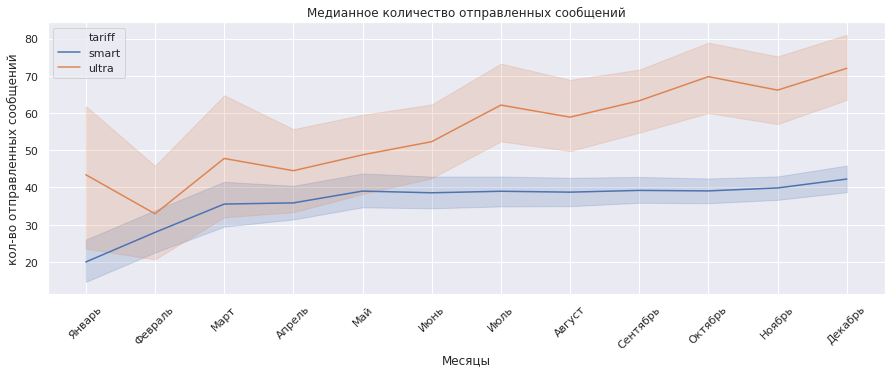

In [53]:
print_df(df_messages_pv_users,'Медианное количество отправленных сообщений', 'кол-во отправленных сообщений')

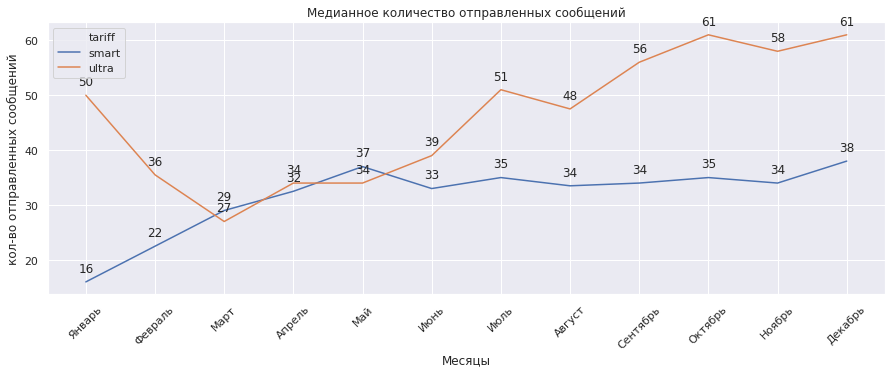

In [54]:
print_df1(df_messages_pv_users,'Медианное количество отправленных сообщений', 'кол-во отправленных сообщений','median')

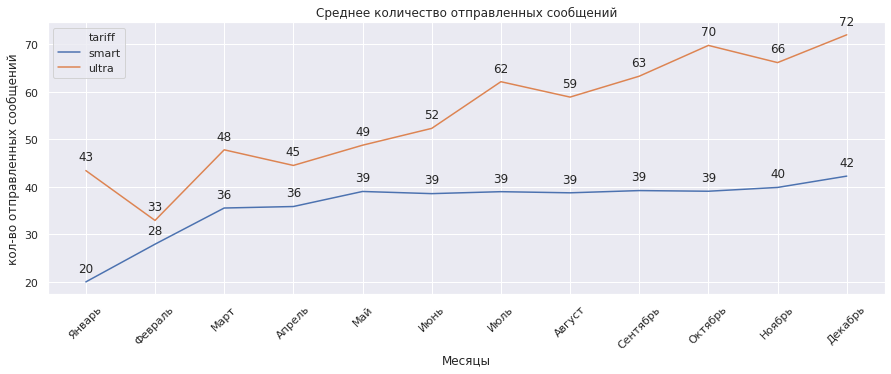

In [55]:
print_df1(df_messages_pv_users,'Среднее количество отправленных сообщений', 'кол-во отправленных сообщений','mean')

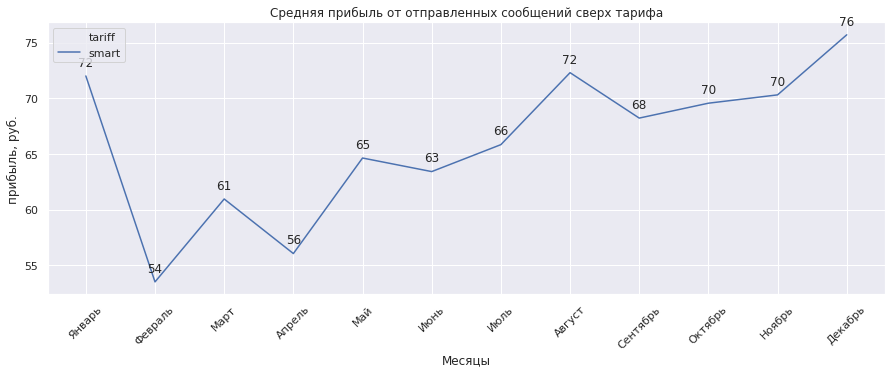

In [56]:
print_df1(df_messages_pv_users1,'Средняя прибыль от отправленных сообщений сверх тарифа', 'прибыль, руб.','mean') 

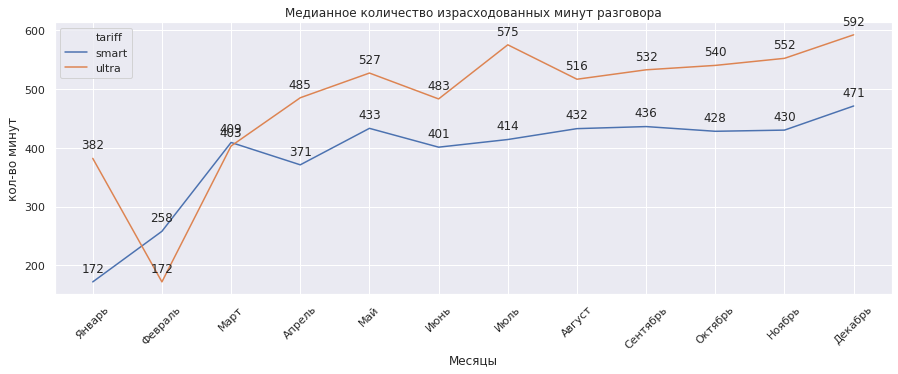

In [57]:
print_df1(df_calls_pv_users,'Медианное количество израсходованных минут разговора', 'кол-во минут','median')

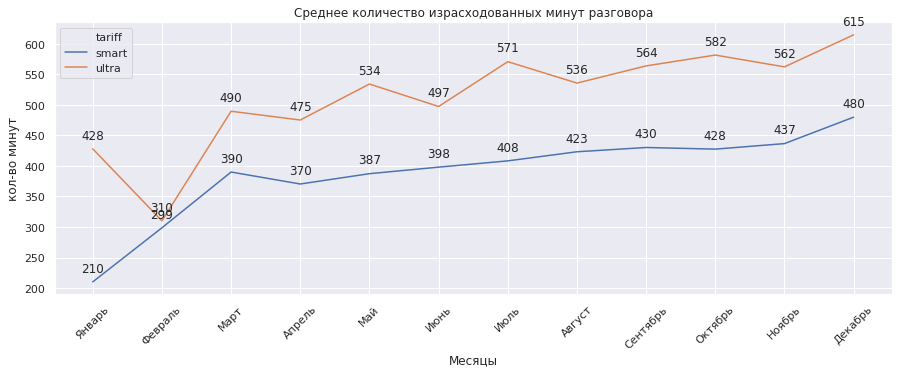

In [58]:
print_df1(df_calls_pv_users,'Среднее количество израсходованных минут разговора', 'кол-во минут','mean')

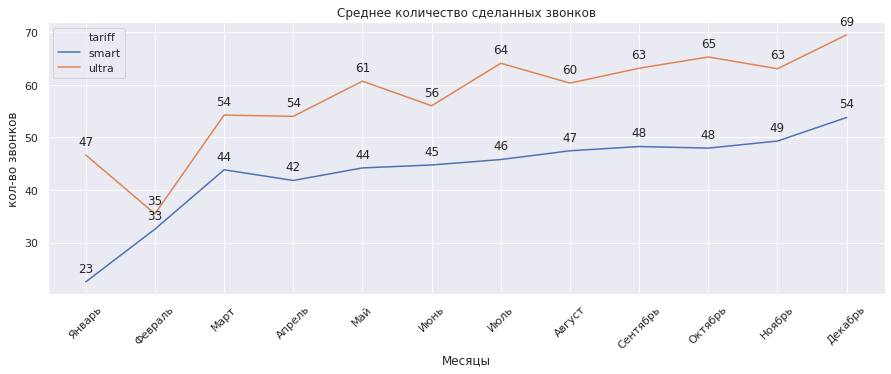

In [59]:
print_df1(df_calls_count_pv_users,'Среднее количество сделанных звонков', 'кол-во звонков','mean')

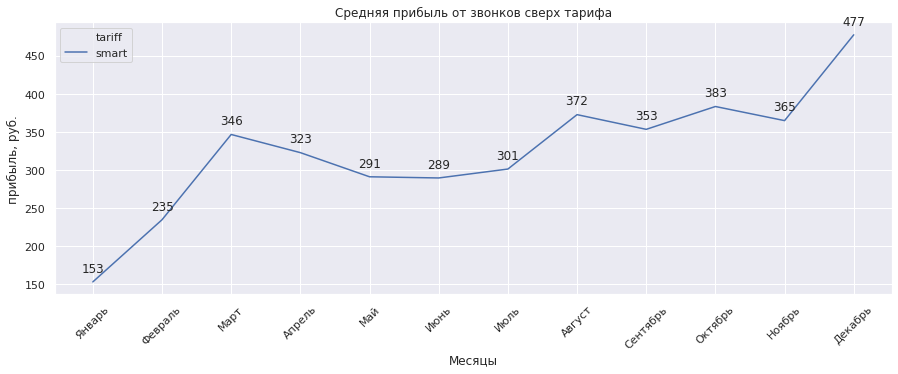

In [60]:
print_df1(df_calls_pv_users1,'Средняя прибыль от звонков сверх тарифа', 'прибыль, руб.','mean')

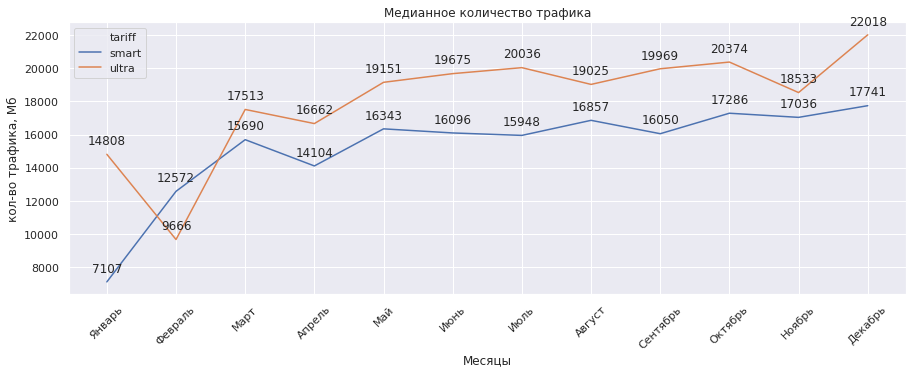

In [61]:
print_df1(df_internet_pv_users,'Медианное количество трафика', 'кол-во трафика, Мб','median')

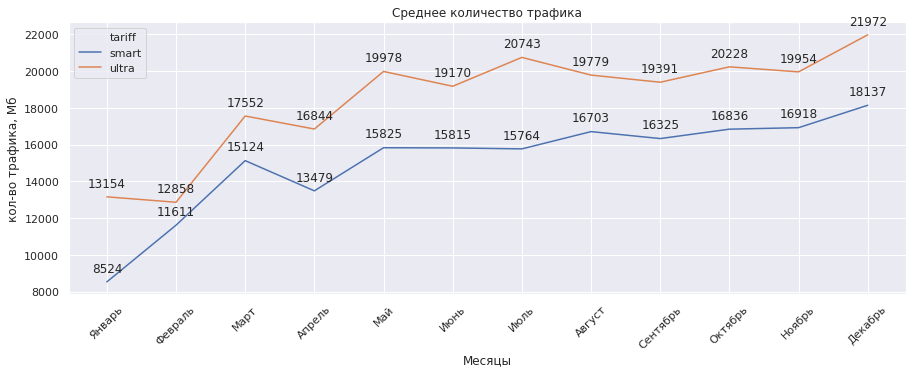

In [62]:
print_df1(df_internet_pv_users,'Среднее количество трафика', 'кол-во трафика, Мб','mean')

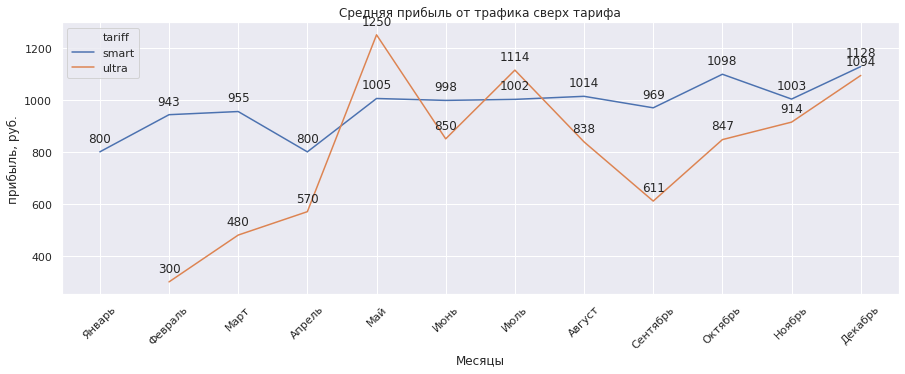

In [63]:
print_df1(df_internet_pv_users1,'Средняя прибыль от трафика сверх тарифа', 'прибыль, руб.','mean')

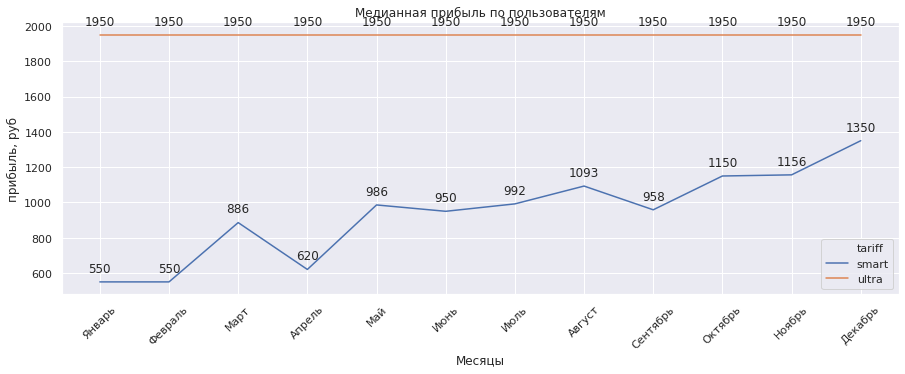

In [64]:
print_df1(df_users_profit2,'Медианная прибыль по пользователям', 'прибыль, руб','median')

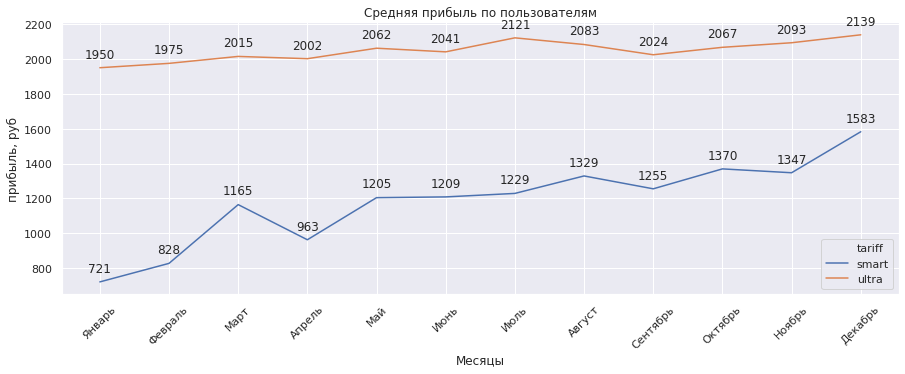

In [65]:
print_df1(df_users_profit2,'Средняя прибыль по пользователям', 'прибыль, руб','mean')

Text(31.569954861111114, 0.5, 'Прибыль, руб')

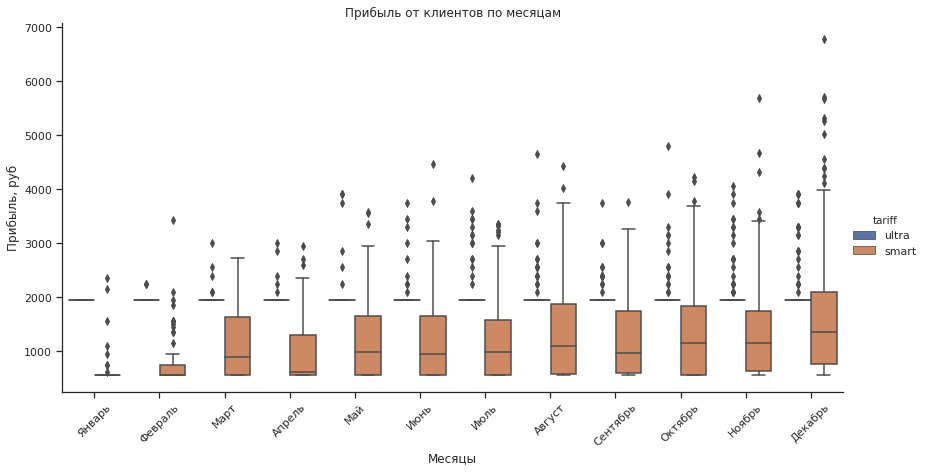

In [66]:
import seaborn as sns
sns.set()
with sns.axes_style(style='ticks'):
    g = sns.catplot('Month', 'Profit', 'tariff', data=df_users_profit3, kind="box", height=6, aspect=2)
plt.xticks(range(0,12), ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль',
                  'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
plt.xticks(rotation=45) 
plt.title('Прибыль от клиентов по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Прибыль, руб')

_Продвигать надо тариф Смарт.
Медианная прибыль у клиентов тарифа Смарт меньше, чем у клиентов тарифа Ультра. Клиенты тарифа Смарт платят ощутимо больше медианной суммы._

Text(0, 0.5, 'Прибыль, руб')

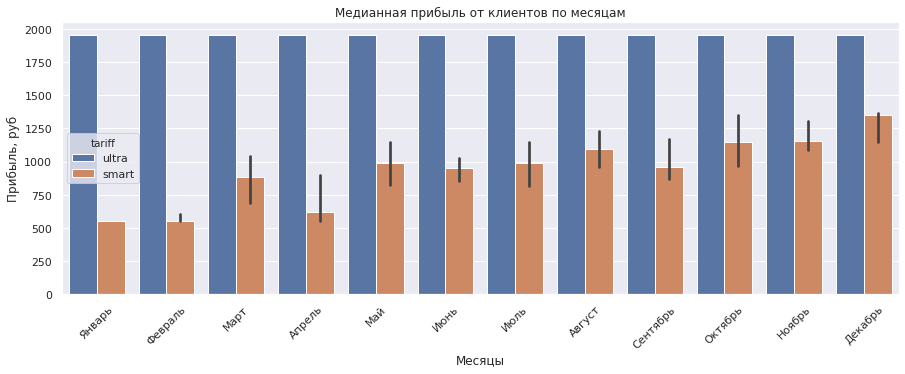

In [67]:
#sns.barplot(x='tariff', y='Profit', data=df_users_profit3);
from numpy import median
fig = plt.figure(figsize=(15,5))
sns.barplot(x='Month', y='Profit', hue='tariff', data=df_users_profit3, estimator=median);
plt.xticks(range(0,12), ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль',
                  'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
plt.xticks(rotation=45) 
plt.title('Медианная прибыль от клиентов по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Прибыль, руб')

_Построим графики показывающие сколько звонков совершили клиенты разных тарифов и сколько израсходованно трафика по дня недели_

In [68]:
def my_heatmap(my_df,index1, column1, value1):
    d = my_df.groupby(['user_id',column1])[value1].sum()
    s = d.reset_index()
    s = s.merge(df_users[['user_id',index1]], on='user_id', how='inner') #объеденяем таблицы
    f, ax = plt.subplots(figsize=(15, 6))
    df = s.pivot_table(index=index1, 
                               columns=column1, values=value1, aggfunc=np.median) #median
    sns.heatmap(df, annot=True, fmt=".0f", ax=ax)
    plt.show()

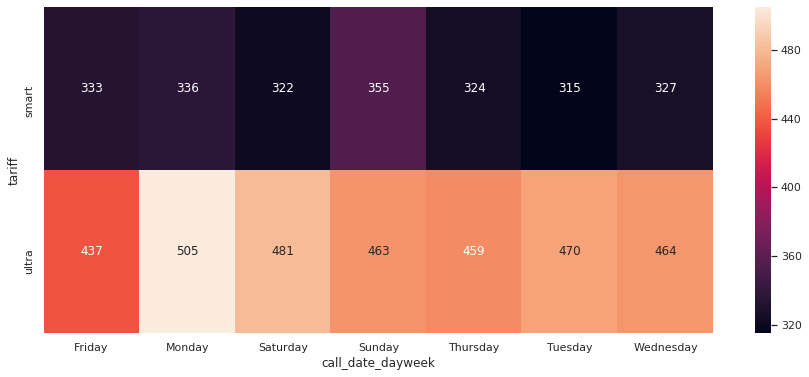

In [69]:
my_heatmap(df_calls,'tariff','call_date_dayweek','duration')

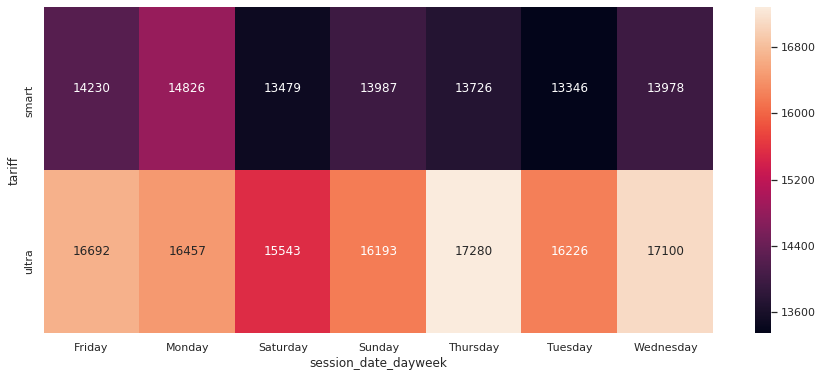

In [70]:
my_heatmap(df_internet,'tariff','session_date_dayweek','mb_used')

#### Промежуточные выводы  <a class="anchor" id="third0-conclusion"></a>
1. Клиенты тарифа Ультра больше делаю звонков в Понедельник, и меньше всего в Пятницу
2. Клиенты тарифа Смарт больше делаю звонков в Восресенье, и меньше всего во Вторник
3. Клиенты тарифа Ультра больше использую интернет в Четверг, и меньше всего в Субботу
4. Клиенты тарифа Смарт больше использую интернет в Понедельник, и меньше всего во Вторник
5. Вероятно у клиентов тарифов Ультра и Смарт разные сферы деятельности и даже отношение к жизни.
6. Медианная прибыль от клиентов тарифа Ультра остается почти неизменной втечение года.
7. Медианная прибыль от клиентов тарифа Смарт выросла в два раза втечение года, а средняя прибыль - почти в 3 раза.
8. Прибыль от клиентов тарифа Смарт растёт такими темпами, что значение верхнего квантиля(75%) в конце года выше, чем прибыль от клиентов тарифа Ультра.
9. Клиенты тарифа Ультра не используют полностью все 3000 минут, которые предоставлены по тарифу.
10. Клиенты тарифа Смарт, если не укладываются по количеству минут на звонки по тарифу, то тратят от 300 до 400 рублей сверх суммы тарифа.
11. Клиенты тарифа Смарт, если не укладываются по количеству гигабайт по тарифу, то тратят примерно 1000 рублей сверх суммы тарифа.

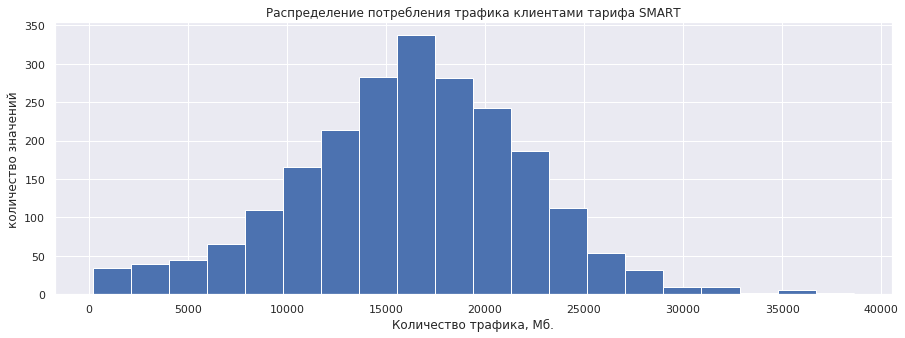

In [71]:
def print_hist_mean(df, title, xlable, index1):
    df_m1 = df.copy()
    df_m1 = df_m1.melt(id_vars=['tariff', 'user_id'], var_name='Month', value_name='Value_per_Month')
    fig = plt.figure(figsize=(15,5))
    df_m1.query('tariff == @index1 & Value_per_Month != 0')['Value_per_Month'].hist(bins = 20)
    plt.title(title)
    plt.ylabel('количество значений')
    plt.xlabel(xlable)
    
print_hist_mean(df_internet_pv_users,
                'Распределение потребления трафика клиентами тарифа SMART','Количество трафика, Мб.','smart')

_Распределение очень похоже на нормальное распределние._

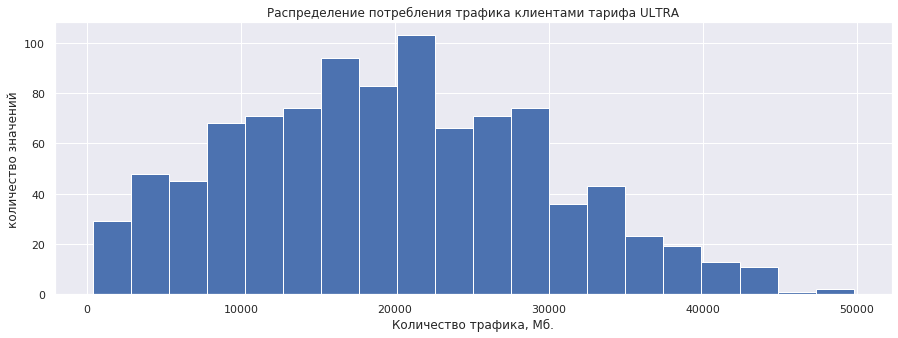

In [72]:
print_hist_mean(df_internet_pv_users,
                'Распределение потребления трафика клиентами тарифа ULTRA','Количество трафика, Мб.','ultra')

_Распределение очень похоже на нормальное распределние со смещение влево. Скорее всего это связанно с малым количеством пользователей, т.к. клиентов тарифа Ультра более чем в 2 раза меньше, чем клиентов тарифа Смарт._

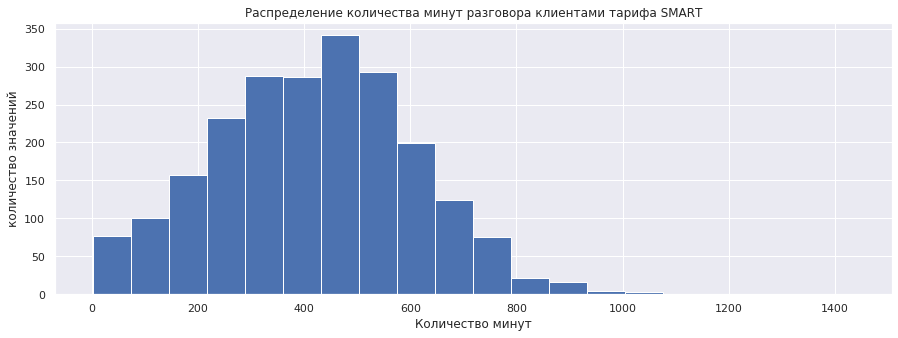

In [73]:
print_hist_mean(df_calls_pv_users,
                'Распределение количества минут разговора клиентами тарифа SMART','Количество минут','smart')

_распределение почти нормальное, но гистограмма скошена влево_

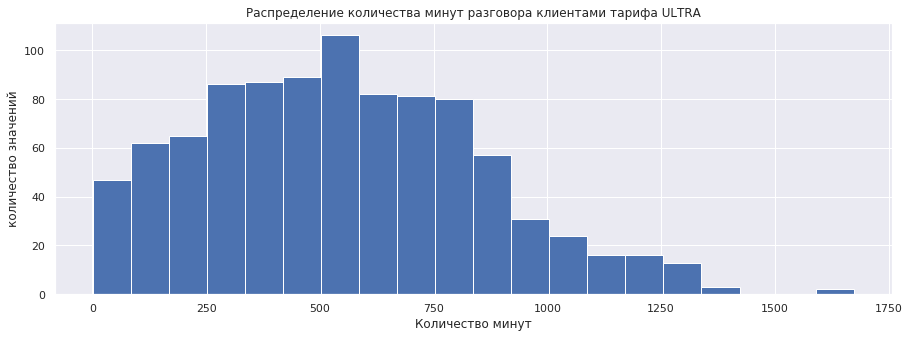

In [74]:
print_hist_mean(df_calls_pv_users,
                'Распределение количества минут разговора клиентами тарифа ULTRA','Количество минут','ultra')

_распределение почти нормальное, но гистограмма скошена влево_

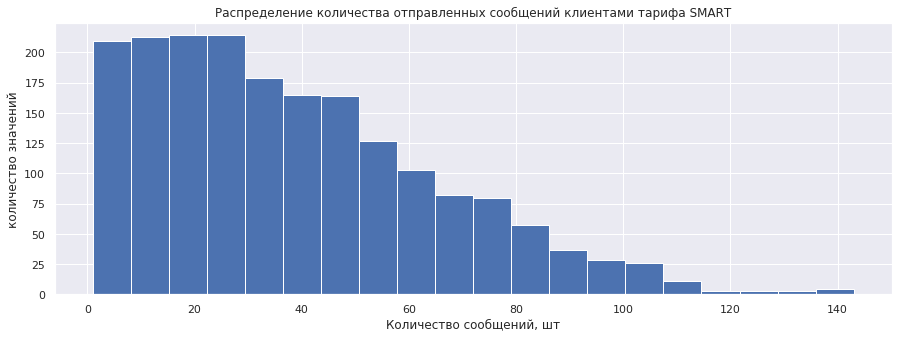

In [75]:
print_hist_mean(df_messages_pv_users,
                'Распределение количества отправленных сообщений клиентами тарифа SMART',
                'Количество сообщений, шт','smart')

_больше похоже на Распределение Пуассона_

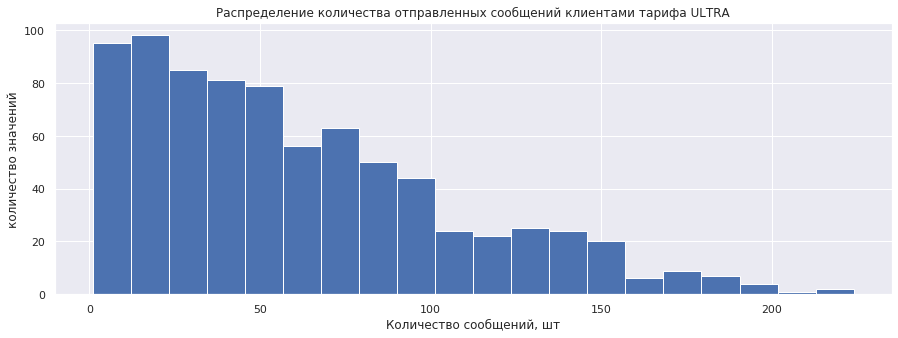

In [76]:
print_hist_mean(df_messages_pv_users,
                'Распределение количества отправленных сообщений клиентами тарифа ULTRA',
                'Количество сообщений, шт','ultra')

_больше похоже на Распределение Пуассона_

_Краткий вывод_
_Теперь посчитаем среднее количество, дисперсию и стандартное отклонение_  
_Напишим для подсчёта функцию_

In [77]:
def count_variance_deviation(df): 
    df_m1 = df.copy()
    df_m1 = df_m1.melt(id_vars=['tariff', 'user_id'], var_name='Month', value_name='Value_per_Month')
    var_mean = df_m1.query('tariff == "ultra" & Value_per_Month != 0')['Value_per_Month'].mean()
    print('Для тарифа ultra среднее значение равно {:.02f}'.format(var_mean))    
    variance_estimate = np.var(df_m1.query('tariff == "ultra" & Value_per_Month != 0')['Value_per_Month'], ddof=1)
    print('Для тарифа ultra дисперсия равна {:.02f}'.format(variance_estimate))
    standard_deviation = np.std(df_m1.query('tariff == "ultra" & Value_per_Month != 0')['Value_per_Month'], ddof=1)
    print('Для тарифа ultra стандартное отклонение равно {:.02f}'.format(standard_deviation))
    var_mean = df_m1.query('tariff == "smart" & Value_per_Month != 0')['Value_per_Month'].mean()
    print('Для тарифа smart среднее значение равно {:.02f}'.format(var_mean))
    variance_estimate = np.var(df_m1.query('tariff == "smart" & Value_per_Month != 0')['Value_per_Month'], ddof=1)
    print('Для тарифа smart дисперсия равна {:.02f}'.format(variance_estimate))
    standard_deviation = np.std(df_m1.query('tariff == "smart" & Value_per_Month != 0')['Value_per_Month'], ddof=1)
    print('Для тарифа smart стандартное отклонение равно {:.02f}'.format(standard_deviation))

Инфорамция о Таблице internet (информация об интернет-сессиях). значения в мегабайтах

In [78]:
count_variance_deviation(df_internet_pv_users)

Для тарифа ultra среднее значение равно 19706.98
Для тарифа ultra дисперсия равна 98746498.93
Для тарифа ultra стандартное отклонение равно 9937.13
Для тарифа smart среднее значение равно 16243.76
Для тарифа smart дисперсия равна 34340091.55
Для тарифа smart стандартное отклонение равно 5860.04


Инфорамция о Таблице messages (информация о сообщениях). значения в штуках

In [79]:
count_variance_deviation(df_messages_pv_users)

Для тарифа ultra среднее значение равно 61.16
Для тарифа ultra дисперсия равна 2109.66
Для тарифа ultra стандартное отклонение равно 45.93
Для тарифа smart среднее значение равно 38.72
Для тарифа smart дисперсия равна 717.59
Для тарифа smart стандартное отклонение равно 26.79


Инфорамция о Таблице calls (информация о звонках). значение в минутах

In [80]:
count_variance_deviation(df_calls_pv_users)

Для тарифа ultra среднее значение равно 547.76
Для тарифа ultra дисперсия равна 93338.43
Для тарифа ultra стандартное отклонение равно 305.51
Для тарифа smart среднее значение равно 419.44
Для тарифа smart дисперсия равна 35718.13
Для тарифа smart стандартное отклонение равно 188.99


Инфорамция о таблице с прибылью по клиентам. Значение в рублях

In [81]:
count_variance_deviation(df_users_profit2)

Для тарифа ultra среднее значение равно 2071.07
Для тарифа ultra дисперсия равна 143491.24
Для тарифа ultra стандартное отклонение равно 378.80
Для тарифа smart среднее значение равно 1294.64
Для тарифа smart дисперсия равна 673931.32
Для тарифа smart стандартное отклонение равно 820.93


### Вывод. <a class="anchor" id="third-conclusion"></a>

Значения стандартного отклонения для тарифа Ультра в таблицах о звонках, сообщениях и интернет-трафике говорят о большом разбросе. Вероятно сказывается малочилслиность представленной группы - всего 150 клиентов. Это значение в два раза выше, чем стандартное отклонение для тарифа Смарт в таблицах о звонках, сообщениях и интернет-трафике.

В тоже время, в таблице о прибылях стандартное отклонение для тарифа Смарт более чем в два разы больше, чем стандартное отклонение для тарифа Ультра.

Клиенты тарифа Ультра укладываются в показатели своего тарифа, а клиенты тарифа Смарт более чем в два раза переплачивают.

### Шаг 4. Проверьте гипотезы: <a class="anchor" id="fourth-step"></a>

<li>средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;</li>  
<li>средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;</li>  

Пороговое значение alpha задайте самостоятельно.  
Поясните:
<li>как вы формулировали нулевую и альтернативную гипотезы;</li>
<li>какой критерий использовали для проверки гипотез и почему.</li>

_Построим графики средней прибыли по тарифам и городам_

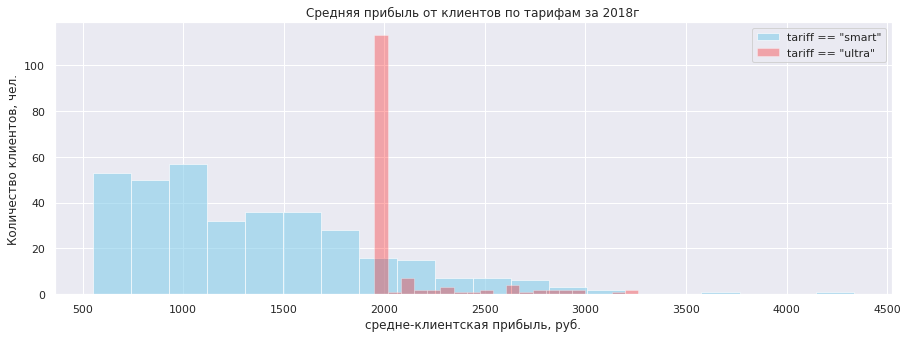

In [84]:
def print_df_hist(df, title, index1, index2):
    df_m1 = df.query(index1).pivot_table(index=['user_id'], values = 'Profit', aggfunc = 'mean')
    df_m2 = df.query(index2).pivot_table(index=['user_id'], values = 'Profit', aggfunc = 'mean')
    fig = plt.figure(figsize=(15,5))
    plt.title(title)
    sns.distplot(df_m1['Profit'] , bins = 20 ,kde = False, color="skyblue", label=index1, hist_kws = {'alpha' :0.6})  
    sns.distplot(df_m2['Profit'] , bins = 20 ,kde = False, color="red", label=index2, hist_kws = {'alpha' :0.3}) 
    plt.ylabel('Количество клиентов, чел.')
    plt.xlabel('средне-клиентская прибыль, руб.')
    plt.legend()
    plt.show()

print_df_hist(df_users_profit3, 'Средняя прибыль от клиентов по тарифам за 2018г','tariff == "smart"','tariff == "ultra"')

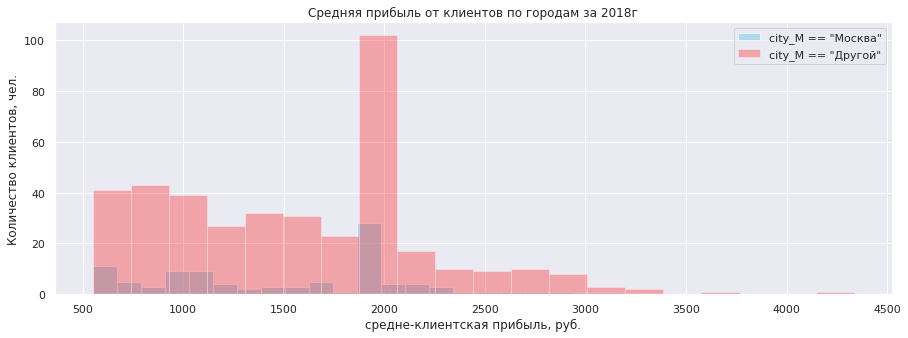

In [85]:
print_df_hist(df_users_profit3, 'Средняя прибыль от клиентов по городам за 2018г','city_M == "Москва"','city_M == "Другой"')

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам,  
примените метод scipy.stats.ttest_ind (array1, array2, equal_var).  
Методу передают параметры:
<li>array1, array2 — массивы, содержащие выборки;</li>
<li>equal_var (от англ. equal variance, «равная дисперсия») — необязательный параметр, задающий считать ли равными дисперсии выборок. Передаётся как "equal_var = True" или "equal_var = False" (True — считать, False — не считать).</li>

Уровень значимости или p-value  — это суммарная вероятность того, что измеренное эмпирически значение окажется далеко от среднего

Так как выборки по тарифам и по городам получены из одной генеральной совокупности, то параметр equal_var функции scipy.stats.ttest_ind выставим в True.

In [86]:
from scipy import stats as st

def proverka_hypotizy(sample_1,sample_2):
    alpha = .05 # критический уровень статистической значимости
                # если p-value окажется меньше него - отвергнем гипотезу

    results = st.ttest_ind(
        sample_1, 
        sample_2,equal_var = True)

    print('p-значение: {:.2%}'.format(results.pvalue))

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

_**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**_  
Начнём с формулировки нулевой гипотезы H₀. H₀ всегда формулируется так, чтобы использовать знак равенства.
В нашем случае гипотезы H₀ будет звучать так:
<blockquote>Средняя выручка пользователей тарифов "Ультра" и "Смарт" не различаются</blockquote>

Исходя из H₀ формулируется альтернативная гипотеза H₁. Для этой H₀ она звучит как «среднее генеральной совокупности не равно A». В нашем случае гипотезы H₁ будет звучать так:
<blockquote>Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются</blockquote>

In [87]:
proverka_hypotizy(df_users_profit3.query('tariff == "ultra"')['Profit'],df_users_profit3.query('tariff == "smart"')['Profit'])

p-значение: 0.00%
Отвергаем нулевую гипотезу


**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**  
Начнём с формулировки нулевой гипотезы H₀. H₀ всегда формулируется так, чтобы использовать знак равенства.
В нашем случае гипотезы H₀ будет звучать так:
<blockquote>Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов не различаются</blockquote>

Исходя из H₀ формулируется альтернативная гипотеза H₁. Для этой H₀ она звучит как «среднее генеральной совокупности не равно A». В нашем случае гипотезы H₁ будет звучать так:
<blockquote>Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов различаются</blockquote>

In [88]:
proverka_hypotizy(df_users_profit3.query('city_M == "Москва"')['Profit'],df_users_profit3.query('city_M == "Другой"')['Profit'])

p-значение: 53.17%
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка клиентов из разных городов и неодинакова, с вероятностью в почти 53% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

### Вывод. <a class="anchor" id="fourth-conclusion"></a>

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов не различаются
3. На графиках эти выводы очень заметны.

### Шаг 5. Общий вывод <a class="anchor" id="fifth-step"></a>

Итак.
<ul>Предоставленных данных было пять таблиц:
<li>Таблица users (информация о пользователях)</li>
<li>Таблица calls (информация о звонках)</li>
<li>Таблица messages (информация о сообщениях)</li>
<li>Таблица internet (информация об интернет-сессиях)</li>
<li>Таблица tariffs (информация о тарифах)</li>
</ul>
<ul>
<li>1. Пропущенных данных было очень мало.</li>
<li>2. Но вместе с тем было обнаружено очень много несостоявщихся звонков и интернет-сессий, вероятно были проблемы с уровнем сигнала, где находился клиент. Пришлось удалить 20% информации о звонках и 13% информации об интернет-сессиях. Компании нужно серьезно озаботиться о предоставлении качества услуги, если 20% звонков у 500 клиентов не могли быть выполнены. Или же это какая-то ошибка выгрузки данных.</li>
<li>3. В предоставленном датасете малое количество пользователей для выработки значимых гипотиз.</li>
<li>4. Распределение пользователей в течение года неоднородно, фактически пользователи начали пользоваться тарифами с середины года. Т.е. по сути данные за полгода, а не за год как написано в описании.</li>
<li>5. Клиенты разных тарифов ведут себя по разному и по разному используют услуги втечении недели. Вероятно, разная модель поведения обусловалена принадлежностью к разным стратам общества. Для проверки этой гипотизы мало данных о пятиста клиентов.</li>
<li>6. Распределение количества использованных минут и интернет-трафика похоже на нормальное. Тогда, как распределение количества отправленных сообщений похоже на распределение Пуассона.</li>
<li>7. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.</li>
<li>8. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов не различаются</li>
<li>9. Медианная прибыль от клиентов тарифа Ультра остается почти неизменной втечение года.</li>
<li>10. Медианная прибыль от клиентов тарифа Смарт выросла в два раза втечение года, а средняя прибыль - почти в 3 раза.</li>
<li>11. Прибыль от клиентов тарифа Смарт растёт такими темпами, что значение верхнего квантиля(75%) в конце года выше, чем прибыль от клиентов тарифа Ультра. Тем, самым можно по рекомендовать его продвижение для увеличения прибыли компании.</li>
<li>12. Клиенты тарифа Ультра не используют полностью все 3000 минут, которые предоставлены по тарифу.</li>
<li>13. Клиенты тарифа Смарт, если не укладываются по количеству минут на звонки по тарифу, то тратят от 300 до 400 рублей сверх суммы тарифа.</li>
<li>14. Клиенты тарифа Смарт, если не укладываются по количеству гигабайт по тарифу, то тратят примерно 1000 рублей сверх суммы тарифа.</li>
<li>15. Клиенты тарифа Ультра, если не укладываются по количеству гигабайт по тарифу, то тратят примерно от 500 до 900 рублей сверх суммы тарифа.</li>
<li>16. Из п.13-15 можно предположит, что поведение клиентов сводится в большей стпени к потреблению интернет-трафика, чем выполнению звонков. Тем самым, компания «Мегалайн» — федерального оператора сотовой связи, превращается в федерального интернет-провайдера.</li>
    </ul>